In [1]:
!pip install shap

In [2]:
#############################################################
#IMPORTING THE LIBRARIES
#############################################################
import numpy as np
import shap
import pandas as pd
from pandas import read_excel
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay
import seaborn as sns
import os
import scipy as sp
import math
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [3]:
#############################################################
#Functions
#############################################################
def evaluation_metrics(y_test, y_pred):
  #confusion matrix
  conf_mat = confusion_matrix(y_test, y_pred)
  TP = conf_mat[0,0]
  TN = conf_mat[1,1]
  FP = conf_mat[1,0]
  FN = conf_mat[0,1]


  #metrics
  Population = TN+FN+TP+FP
  CH= ((TP+FN)*(TP+FP))/Population
  Prevalence = round( (TP+FN) / Population,2)
  Accuracy   = round( (TP+TN) / Population,2)
  TNR = round(TN/(TN+FP),2)
  TPR = round(TP/(TP+FN),2)
  FPR = round(FP/(TN+FP),2)
  FNR = round(FN/(TP+FN),2)
  PPV = round(TP / (TP+FP),2)
  NPV = round(TN/(TN+FN),2)
  LRp = round(TPR/FPR,2)
  LRn = round(FNR/TNR,2)
  f1 = round( TP/(TP+0.5*(FP+FN)) ,2)
  Precision = round(TP/(TP+FP),2)
  MCC = round(((TP*TN)-(FP*FN))/math.sqrt( (TP+FP)*(TP+FN)*(TN+FP)*(TN+FN) ),2)

  #dic
  metrics = {
        'TP': TP,
        'TN': TN,
        'FP': FP,
        'FN': FN,
        'FPR': FPR,
        'FNR': FNR,
        'PPV': PPV,
        'NPV': NPV,
        'Prevalence': Prevalence,
        'Specificity': TNR,
        'Sensitivity': TPR,
        'Accuracy': Accuracy,
        'Precision': Precision,
        'MCC': MCC,
        'f1':f1,
        'LH+': LRp,
        'LH-': LRn
    }

  return metrics

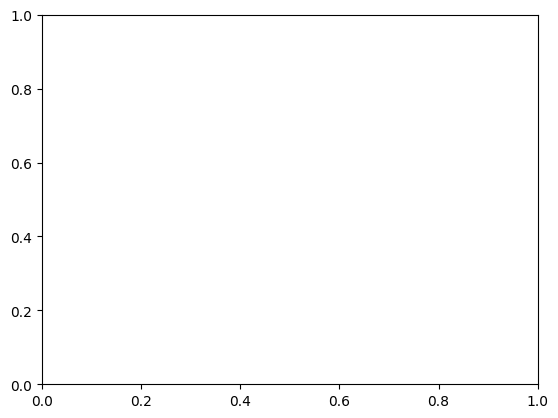

In [4]:
#Useful stuff
ax = plt.gca()

# LOADING THE DATASET

In [5]:
# LOADING THE DATASET
my_sheet = 'SACS 12 meses' # change it to your sheet name, you can find your sheet name at the bottom left of your excel file
file_name = 'Dataset preterm 12 month SACS.xlsx' # change it to the name of your excel file
df = read_excel(file_name, sheet_name = my_sheet)

#Feature selection

In [6]:
#############################################################
#Feature selection after the prune process
#############################################################
df= df.loc[:,["SACS","min_dist_ojos", "std_Y","media_temp_ojo_izq","media_temp_ojo_der","Complexity_pupila_izq","Complexity_pupila_der", 'var_Y','T_der_izq']]
df.columns = ["SACS","min_dist_AOI_eyes", "std_gaze_Y_coor","Average_left_pupil_diameter","Average_right_pupil_diameter",
              "Complexity_left_pupil","Complexity_right_pupil", 'var_gaze_Y_coor','Pupil_diameter_symmetricity']
#df.drop(['Unnamed: 0', 'Nombre bebe','Estimulo', 'Edad','min_dif_Z','max_dif_Z','rango_dif_Z',
#         'min_dist_cen_gravedad','max_dist_cen_gravedad','radio_toro_cen_gravedad',
#         ], axis = 'columns', inplace=True)

#df.drop(['Unnamed: 0', 'Nombre bebe','Estimulo', 'Edad','max_dist_ojos','max_dist_boca','radio_toro_ojos', 'radio_toro_boca',
#          'segundos_fijacion_ojos','segundos_fijacion_boca','porcentaje_fijacion_ojos','porcentaje_fijacion_boca',
#          'std_X', 'var_X','cor_Pearson', 'var_Y','T_izq_der','T_der_izq','min_dist_boca','min_dif_Z','max_dif_Z','rango_dif_Z',
#          'min_dist_cen_gravedad','max_dist_cen_gravedad','radio_toro_cen_gravedad' ], axis = 'columns', inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 194 entries, 0 to 193
Data columns (total 9 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   SACS                          194 non-null    int64  
 1   min_dist_AOI_eyes             194 non-null    float64
 2   std_gaze_Y_coor               194 non-null    float64
 3   Average_left_pupil_diameter   194 non-null    float64
 4   Average_right_pupil_diameter  194 non-null    float64
 5   Complexity_left_pupil         194 non-null    float64
 6   Complexity_right_pupil        194 non-null    float64
 7   var_gaze_Y_coor               194 non-null    float64
 8   Pupil_diameter_symmetricity   194 non-null    float64
dtypes: float64(8), int64(1)
memory usage: 13.8 KB


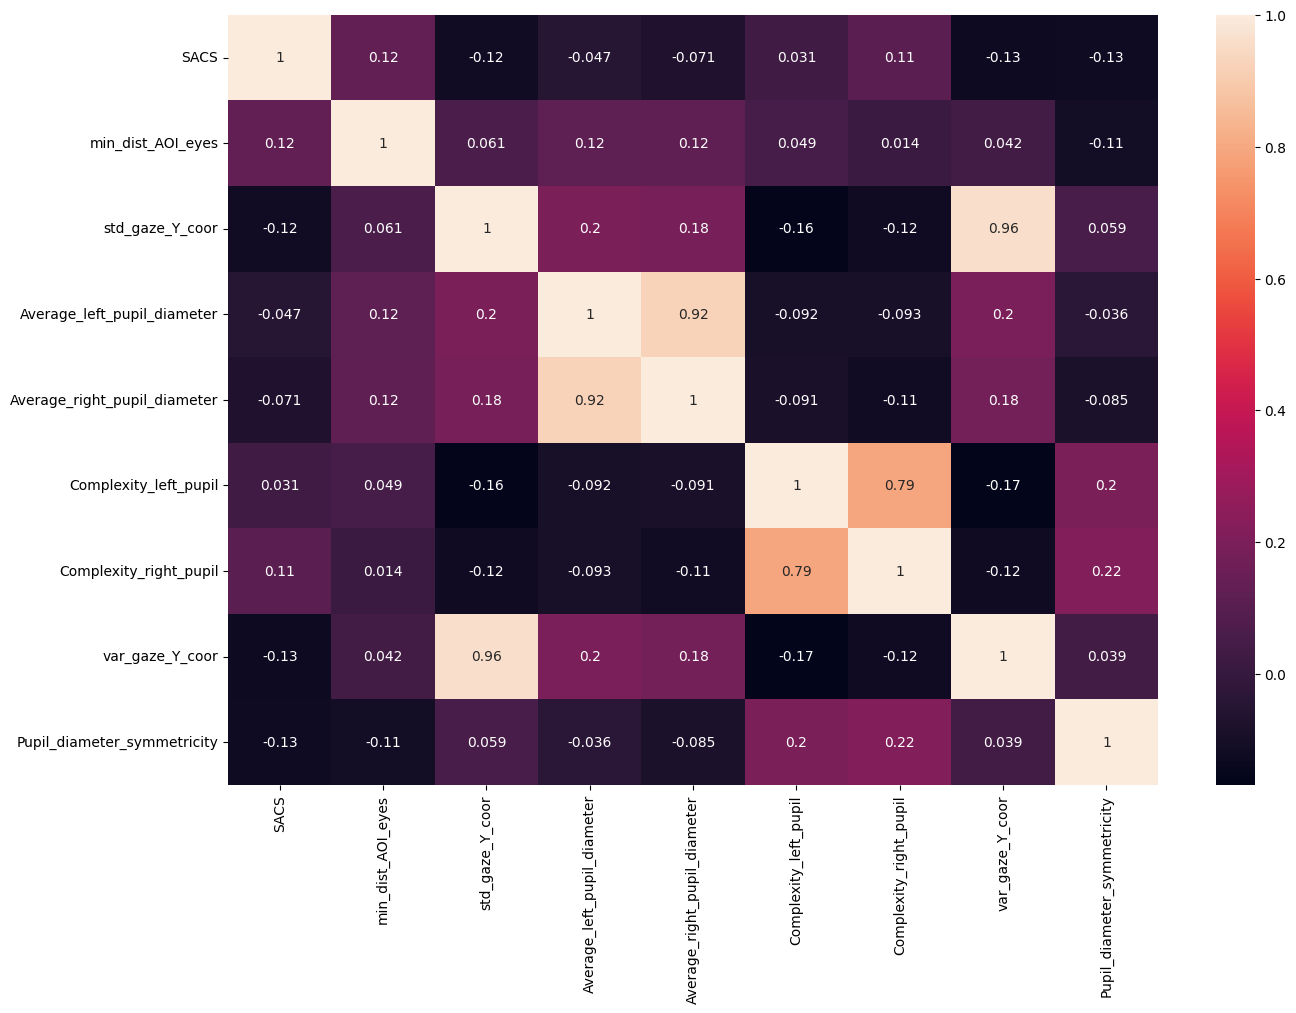

In [7]:
corr_df = df.corr(method='pearson')
import seaborn as sns
plt.figure(figsize=(15, 10))
sns.heatmap(corr_df, annot=True)
plt.show()

In [8]:
# Normalize the dataset
minmax=MinMaxScaler()
data=pd.DataFrame(minmax.fit_transform(df),columns=df.columns)
data

,SACS,min_dist_AOI_eyes,std_gaze_Y_coor,Average_left_pupil_diameter,Average_right_pupil_diameter,Complexity_left_pupil,Complexity_right_pupil,var_gaze_Y_coor,Pupil_diameter_symmetricity
0,1.0,0.147724,0.066084,0.443350,0.483871,0.573427,0.381187,0.008258,0.000000
1,1.0,0.129418,0.416712,0.443350,0.465438,0.174307,0.298177,0.188930,0.000000
2,1.0,0.062653,0.777444,0.261084,0.308756,0.168350,0.181135,0.615197,0.000000
3,1.0,0.006461,0.239487,0.566502,0.566820,0.279332,0.153321,0.068861,0.274286
4,1.0,0.122271,0.115511,0.536946,0.493088,0.419839,0.372117,0.019798,0.256735
...,...,...,...,...,...,...,...,...,...
189,1.0,0.113461,0.414255,0.625616,0.557604,0.409997,0.317699,0.187013,0.228163
190,1.0,0.069604,0.034954,0.502463,0.479263,0.298886,0.304569,0.003353,0.000000
191,1.0,0.147822,0.023484,0.758621,0.695853,0.463740,0.390343,0.002014,0.305714
192,1.0,0.078414,0.300655,0.738916,0.668203,0.395882,0.351473,0.103649,0.223673


# TRAINING AND TESTING DATA

In [9]:
#train_test_splitting of the dataset
x = data.drop(columns = 'SACS')

# Getting Predicting Value
y = data['SACS']

from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.25,random_state=0)

In [10]:
print(len(x_train))
print(len(x_test))
print(len(y_train))
print(len(y_test))

145
49
145
49


# MODELS

1. RandomForestClassifier

In [11]:
from sklearn.ensemble import RandomForestClassifier
rfc=RandomForestClassifier(n_estimators=2000, min_samples_split= 5,  min_samples_leaf= 1, max_features= 'sqrt',
 max_depth= 60, bootstrap= False, random_state = 42)
rfc.fit(x_train,y_train)

RandomForestClassifier(bootstrap=False, max_depth=60, min_samples_split=5,
                       n_estimators=2000, random_state=42)

In [12]:
y_pred=rfc.predict(x_test)
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
print("Classification Report is:\n",classification_report(y_test,y_pred))
print("Confusion Matrix:\n",confusion_matrix(y_test,y_pred))

Classification Report is:
               precision    recall  f1-score   support

         0.0       0.60      0.75      0.67         4
         1.0       0.98      0.96      0.97        45

    accuracy                           0.94        49
   macro avg       0.79      0.85      0.82        49
weighted avg       0.95      0.94      0.94        49

Confusion Matrix:
 [[ 3  1]
 [ 2 43]]


In [13]:
rfc_metrics = evaluation_metrics(y_test,y_pred)

In [14]:
rfc_disp = RocCurveDisplay.from_estimator(rfc, x_test, y_test, ax=ax,alpha=0.8)

In [15]:
df.drop(['SACS'], axis = 'columns', inplace=True)

In [16]:
pd.DataFrame(df.columns, rfc.feature_importances_*100)

,0
11.399613,min_dist_AOI_eyes
12.613154,std_gaze_Y_coor
10.363537,Average_left_pupil_diameter
16.666501,Average_right_pupil_diameter
12.010742,Complexity_left_pupil
18.064228,Complexity_right_pupil
12.355912,var_gaze_Y_coor
6.526313,Pupil_diameter_symmetricity


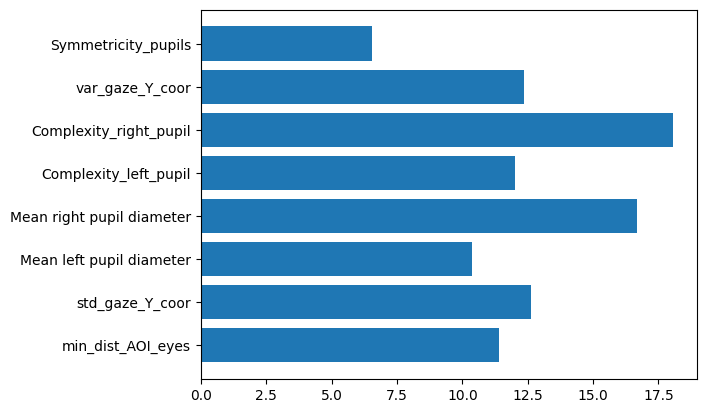

In [17]:
fig, ax = plt.subplots()
ax = plt.barh(['min_dist_AOI_eyes', 'std_gaze_Y_coor', 'Mean left pupil diameter', 'Mean right pupil diameter', 'Complexity_left_pupil', 'Complexity_right_pupil',
               'var_gaze_Y_coor', 'Symmetricity_pupils'], rfc.feature_importances_*100)


#display plot
plt.show()

In [18]:
conf_mat = confusion_matrix(y_test, y_pred)
TP = conf_mat[0,0]
TN = conf_mat[1,1]
FP = conf_mat[1,0]
FN = conf_mat[0,1]

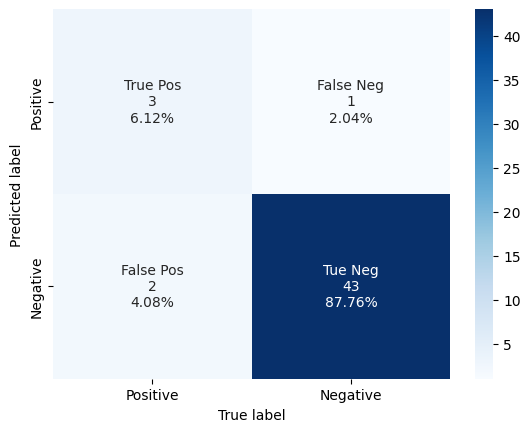

In [19]:
import sklearn.metrics as metrics
cf_matrix =  metrics.confusion_matrix(y_test, y_pred)

group_names = ['True Pos','False Neg','False Pos','Tue Neg']
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
ax.set(xlabel='True label', ylabel='Predicted label')
ax.yaxis.set_ticklabels(['Positive', 'Negative'])
ax.xaxis.set_ticklabels(['Positive', 'Negative'])
plt.show()

2. AdaBoostClassifier

In [20]:
from sklearn.ensemble import AdaBoostClassifier
adb = AdaBoostClassifier(n_estimators=100, learning_rate=1, random_state=0)
adb.fit(x_train,y_train)

AdaBoostClassifier(learning_rate=1, n_estimators=100, random_state=0)

In [21]:
y_pred=adb.predict(x_test)
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
print("Classification Report is:\n",classification_report(y_test,y_pred))
print("Confusion Matrix:\n",confusion_matrix(y_test,y_pred))

Classification Report is:
               precision    recall  f1-score   support

         0.0       0.50      0.75      0.60         4
         1.0       0.98      0.93      0.95        45

    accuracy                           0.92        49
   macro avg       0.74      0.84      0.78        49
weighted avg       0.94      0.92      0.93        49

Confusion Matrix:
 [[ 3  1]
 [ 3 42]]


In [22]:
adb_metrics = evaluation_metrics(y_test,y_pred)

In [23]:
adb_disp = RocCurveDisplay.from_estimator(adb, x_test, y_test, ax=ax,alpha=0.8)

## Cofusion matrix

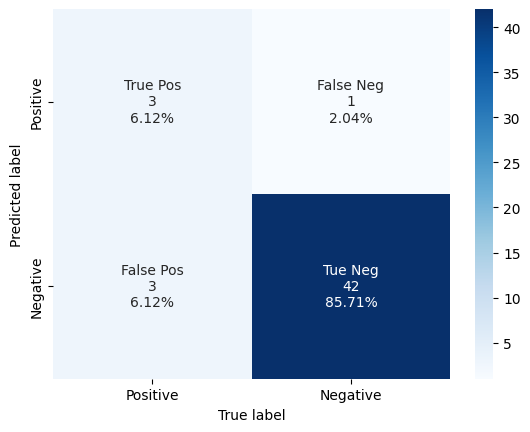

In [24]:
import sklearn.metrics as metrics
cf_matrix =  metrics.confusion_matrix(y_test, y_pred)

group_names = ['True Pos','False Neg','False Pos','Tue Neg']
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
ax.set(xlabel='True label', ylabel='Predicted label')
ax.yaxis.set_ticklabels(['Positive', 'Negative'])
ax.xaxis.set_ticklabels(['Positive', 'Negative'])
plt.show()

## ROC AUC

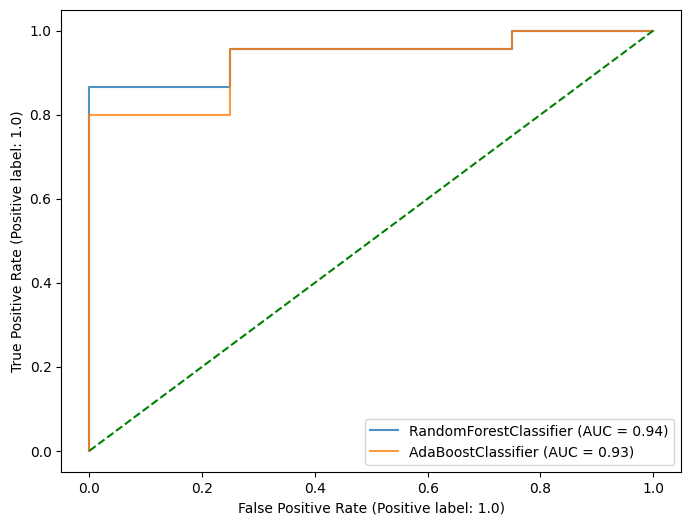

In [25]:
plt.figure(figsize=(8,6))
ax = plt.gca()
rfc_disp = RocCurveDisplay.from_estimator(rfc, x_test, y_test, ax=ax,alpha=0.8)
adb_disp.plot(ax=ax, alpha=0.8)
plt.plot([0, 1], [0, 1], color = 'g', ls='--')
plt.show()

## Evaluation metrics


In [26]:
metrics = [rfc_metrics,adb_metrics]
datos_evaluacion= pd.DataFrame(metrics)
datos_evaluacion.insert(0, "Algoritmo", ['RFC','ADB'], True)
datos_evaluacion

,Algoritmo,TP,TN,FP,FN,FPR,FNR,PPV,NPV,Prevalence,Specificity,Sensitivity,Accuracy,Precision,MCC,f1,LH+,LH-
0,RFC,3,43,2,1,0.04,0.25,0.6,0.98,0.08,0.96,0.75,0.94,0.6,0.64,0.67,18.75,0.26
1,ADB,3,42,3,1,0.07,0.25,0.5,0.98,0.08,0.93,0.75,0.92,0.5,0.57,0.60,10.71,0.27


# XAI

In [27]:
from sklearn.model_selection import train_test_split
import lightgbm as lgb
import shap

# print the JS visualization code to the notebook
shap.initjs()

In [28]:
explainer = shap.TreeExplainer(model=rfc,
                               data=None,
                               model_output = 'raw',
                               feature_pertubation='tree_path_dependent')
shap_values = explainer.shap_values(x_train)

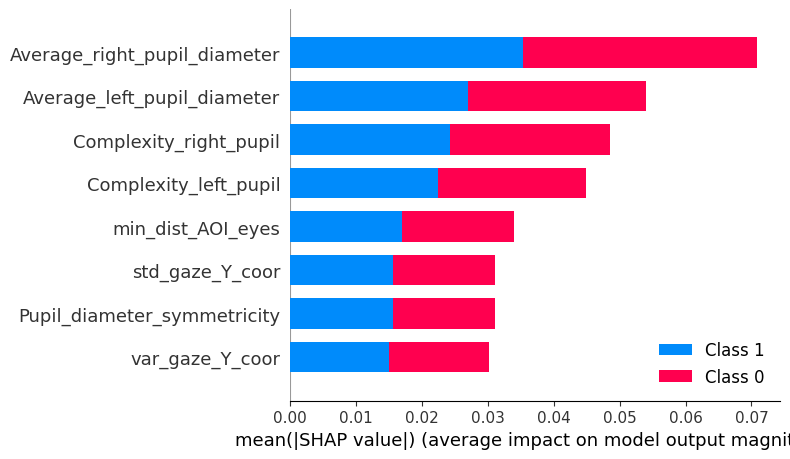

In [29]:
shap.summary_plot(shap_values, x_train, plot_type="bar")

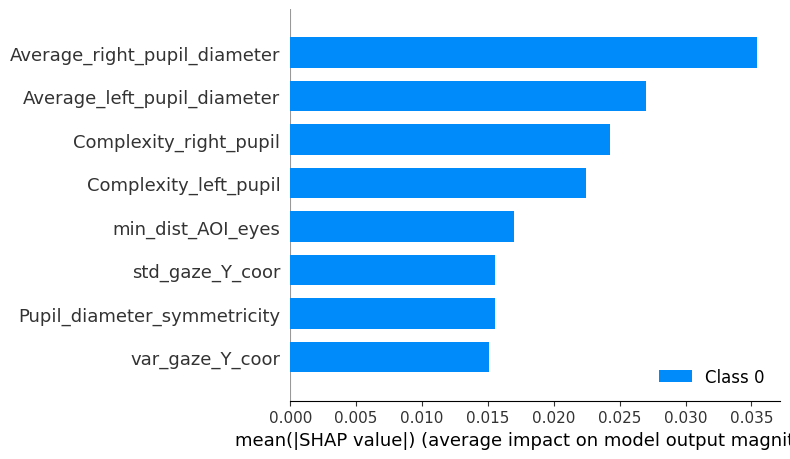

In [30]:
shap.summary_plot(shap_values, x_train, class_inds=[0])

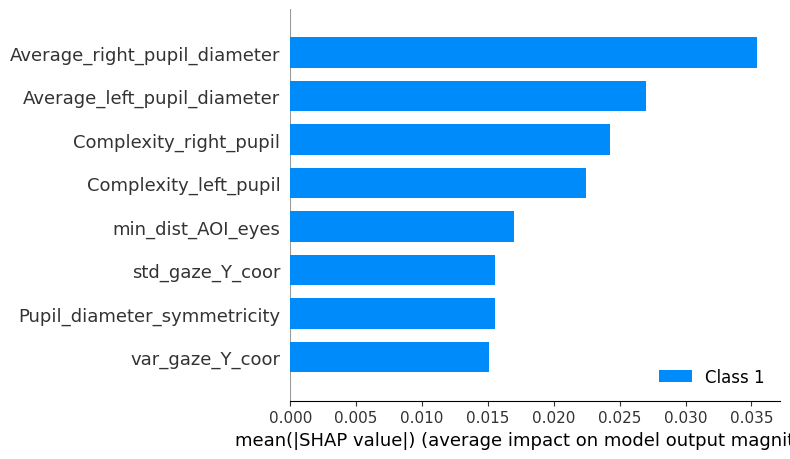

In [31]:
shap.summary_plot(shap_values, x_train, class_inds=[1])

## SHAP Summary Plot

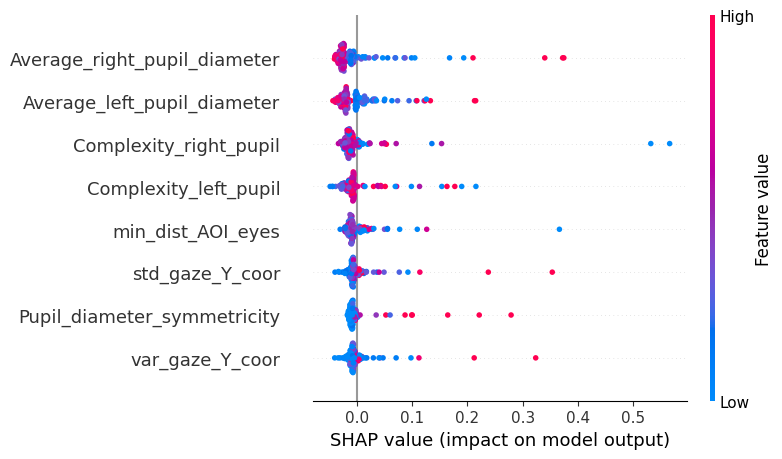

In [32]:
shap.summary_plot(shap_values[0], x_train)

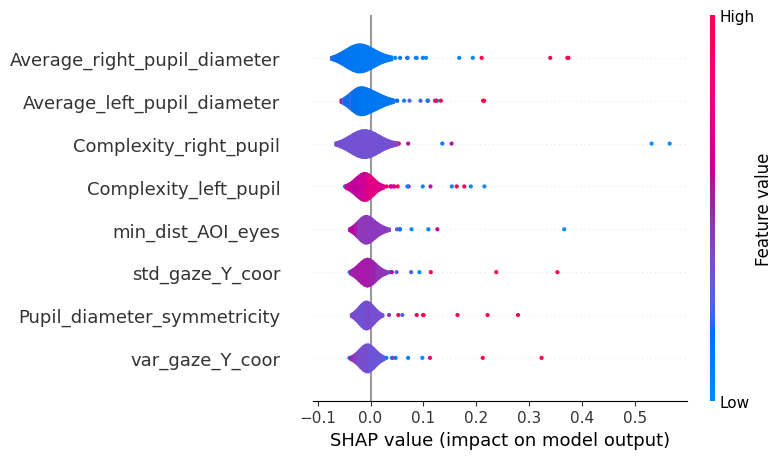

In [33]:
shap.summary_plot(shap_values[0], x_train, plot_type="violin")

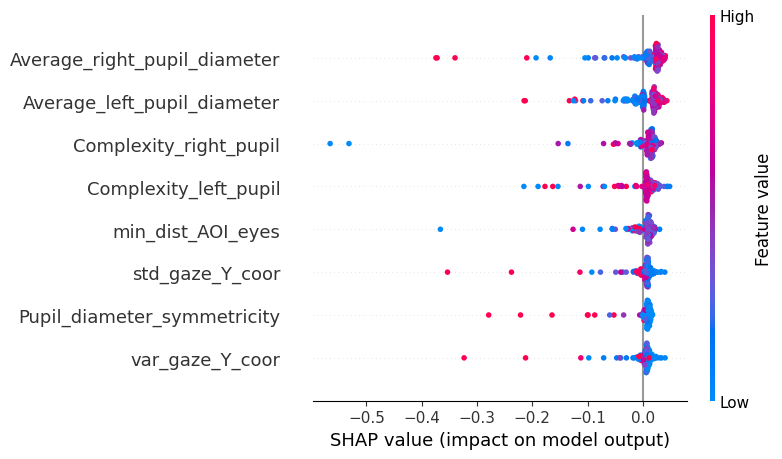

In [34]:
shap.summary_plot(shap_values[1], x_train)

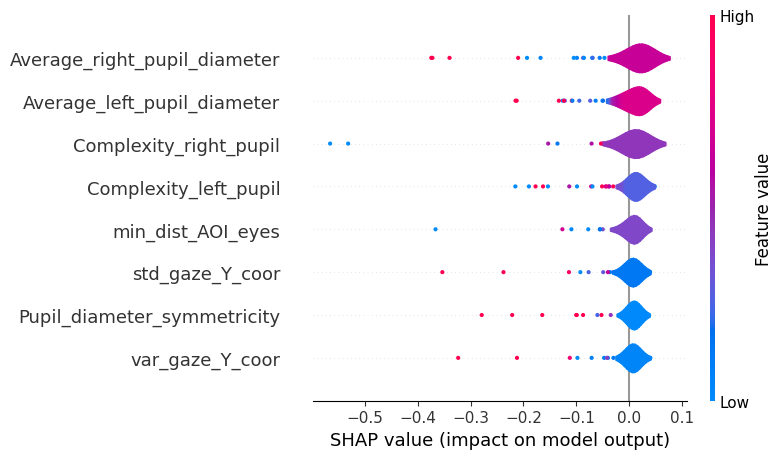

In [35]:
shap.summary_plot(shap_values[1], x_train, plot_type="violin")

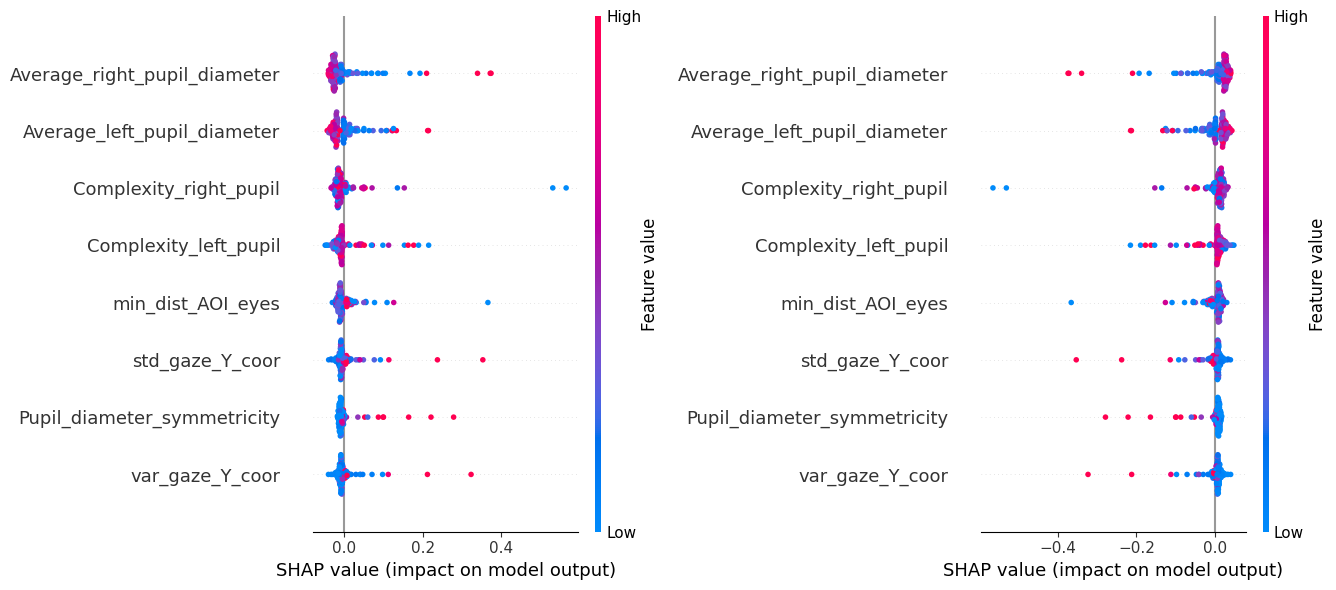

In [36]:
fig = plt.figure()
ax0 = fig.add_subplot(131)
shap.summary_plot(shap_values[0], x_train, show = False)
ax1 = fig.add_subplot(132)
shap.summary_plot(shap_values[1], x_train, show = False)
plt.gcf().set_size_inches(20,6)
plt.tight_layout()
plt.show()

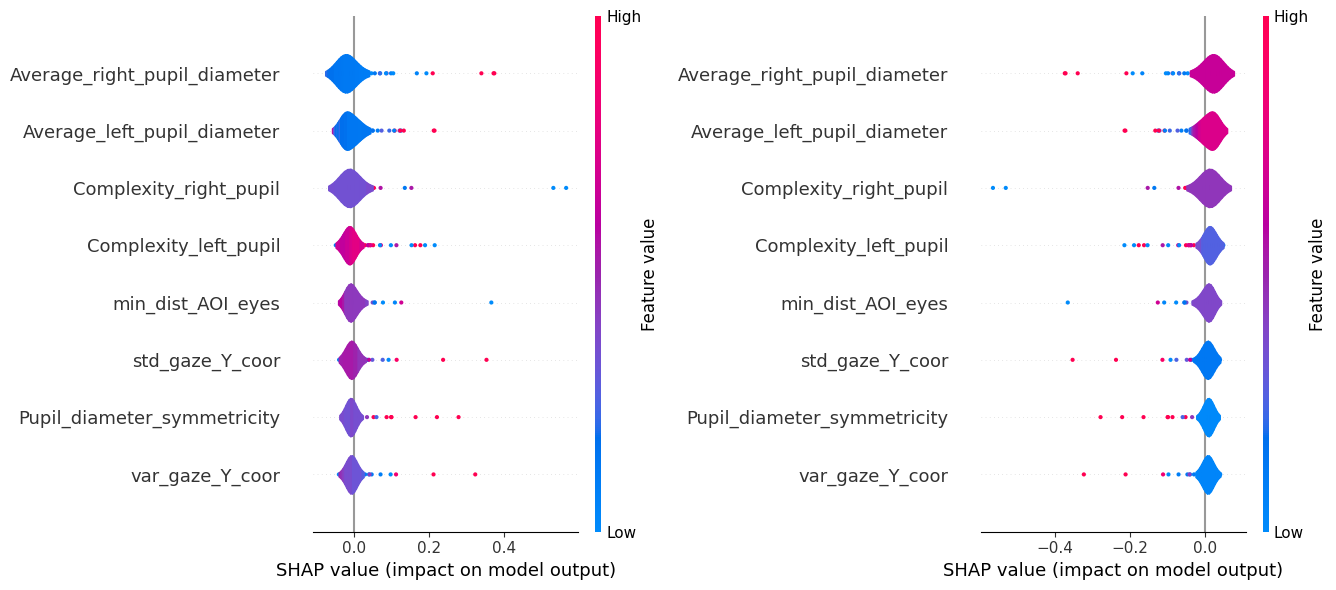

In [37]:
fig = plt.figure()
ax0 = fig.add_subplot(131)
shap.summary_plot(shap_values[0], x_train, plot_type="violin", show = False)
ax1 = fig.add_subplot(132)
shap.summary_plot(shap_values[1], x_train, plot_type="violin", show = False)
plt.gcf().set_size_inches(20,6)
plt.tight_layout()
plt.show()
